In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import geopy.distance
import math

#Cleaning
* Accessing CSVs
* Merging
* Selecting which columns will be important
* Data type reformatting 
* collect/create new information
* Summary statistics - graphs and other important data
 * What do we need to do to use this for training set?

In [ ]:
planes = pd.read_csv("/content/planes.csv", names = ['Plane Name', 'IATA Code', 'ICAO Code'])

In [ ]:
airlines = pd.read_csv("/content/airlines.csv", names = ['Airline ID', 'Airline Name', 'Alias', 'IATA Code', 'ICAO Code', 'Callsign', 'Country', 'Active']) #cols = {'Unique ID', '}
airports = pd.read_csv("/content/airports.csv", names = ['Airport ID', 'Name', 'City','Country','IATA Code','ICAO Code','Latitude','Longitude','Altitude','Timezone','DST','TZ Database','Type (remove this col)','Source (remove this col)'])
routes = pd.read_csv("/content/routes.csv", index_col=None, names = ['IATA/ICAO Code', 'Airline ID', 'Source Airport', 'Source Airport ID', 'Destination Airport', 'Destination Airport ID','Codeshare', 'Stops', 'Equipment'])
planes = pd.read_csv("/content/planes.csv", names = ['Plane Name', 'IATA Code', 'ICAO Code'])

In [ ]:
routes.index.name = 'Index W.R.T. Origin'

Documentation: https://openflights.org/data.html 

In [ ]:
routes = routes.loc[routes['Airline ID'] != '\\N']
routes['Airline ID'] = routes['Airline ID'].astype('int64')
routes = routes.loc[routes['Source Airport ID'] != '\\N']
routes['Source Airport ID'] = routes['Source Airport ID'].astype('int64')
routes = routes.loc[routes['Destination Airport ID'] != '\\N']
routes['Destination Airport ID'] = routes['Destination Airport ID'].astype('int64')
routes['Codeshare'] = np.array(routes['Codeshare'] == 'Y', dtype = 'int32')

routes = routes.dropna()

<ipython-input-5-f7ab7a68809e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  routes['Source Airport ID'] = routes['Source Airport ID'].astype('int64')


In [ ]:
# Added column for Airline names

airline_code_map = {}

for id in airlines['Airline ID']:
  name = str(airlines.loc[airlines['Airline ID'] == id]['Airline Name'])
  airline_code_map[id] = ' '.join(name[:-34].split(' ')[4:])
routes['Airline'] = routes['Airline ID'].map(airline_code_map)

In [ ]:

# Added column for Source and Destination Airports
# Uses same map(ID : Name)

airport_code_map = {}

for id in airports['Airport ID']:
  name = str(airports.loc[airports['Airport ID'] == id]['Name'])
  airport_code_map[id] = ' '.join(name[:-26].split(' ')[4:])
routes['Source Airport'] = (routes['Source Airport ID'].astype('int64').map(airport_code_map))
routes['Destination Airport'] = (routes['Destination Airport ID'].astype('int64').map(airport_code_map))

In [ ]:
# Adds a country identifier for source and destination on route

country_code_map = {}

for id in airports['Airport ID']:
  source_country = str(airlines.loc[airlines['Airline ID'] == id]['Country'])
  country_code_map[id] = ' '.join(source_country[:-29].split(' ')[4:])
routes['Source Country'] = (routes['Source Airport ID'].map(country_code_map))
routes['Destination Country'] = (routes['Destination Airport ID'].astype('int64').map(country_code_map))

In [ ]:
# distance travelled
# Calculates distance between two airports by their latitude and longitude


dists = []
dud_rows = []

float_nan = float('nan')
#calculating distance between lat and lon of source ap and dest ap
for i in range(len(routes)):
  if routes.iloc[i]['Source Airport ID'] in airport_code_map.keys() and routes.iloc[i]['Destination Airport ID'] in airport_code_map.keys():
    lat_source = float(airports[airports['Airport ID'] == routes.iloc[i]['Source Airport ID']].iloc[0]['Latitude'])
    long_source = float(airports[airports['Airport ID'] == routes.iloc[i]['Source Airport ID']].iloc[0]['Longitude'])
    lat_dest = float(airports[airports['Airport ID'] == routes.iloc[i]['Destination Airport ID']].iloc[0]['Latitude'])
    long_dest = float(airports[airports['Airport ID'] == routes.iloc[i]['Destination Airport ID']].iloc[0]['Longitude'])
    


    dists.append(geopy.distance.geodesic((lat_source, long_source), (lat_dest, long_dest)).km)
  else:
    dud_rows.append(i)

    
# d_rows.append(i)



In [ ]:
routes = routes.drop(index = [routes.iloc[i].name for i in dud_rows]) #couldn't get geo-coordinate information from some airports so they get dropped
routes['Distance (KM)'] = dists

In [ ]:
routes.to_csv('routes_clean.csv')

In [ ]:
country_code_map = {}
for id in airports['Airport ID']:
  country = str(airports.loc[airports['Airport ID'] == id]['Country'])
  country_code_map[id] = ' '.join(country[:-29].split(' ')[4:])



In [ ]:
source_countries = routes['Source Airport ID'].map(country_code_map)
routes['Source Country'] = source_countries

In [ ]:
dest_countries = routes['Destination Airport ID'].map(country_code_map)
routes['Destination Country'] = dest_countries

In [ ]:
# THIS cell doesn't work as intended

# planes_code_map = {}

# for code in planes['IATA Code']:
#   plane_model = str(planes.loc[planes['IATA Code'] == code]['Plane Name'])
#   planes_code_map[code] = ' '.join(plane_model[:-32].split(' ')[4:])
# plane_models = routes['Equipment'].map(planes_code_map)
# routes['Equipment'] = plane_models

In [ ]:
routes = routes[['IATA/ICAO Code', 'Airline', 'Airline ID', 'Source Airport', 'Source Country','Source Airport ID', 'Destination Airport', 'Destination Country','Destination Airport ID','Distance (KM)','Equipment','Stops','Codeshare']].rename(columns={'Equipment':'Plane Model'})

In [ ]:
routes.to_csv('routes_clean.csv')

Collect routes df after cleaning

In [ ]:
routes = pd.read_csv("/content/routes_clean.csv", index_col='Index W.R.T. Origin')

##Further cleaning
* I think cleaning is done

In [ ]:
routes_cl = routes.copy(deep=True)

In [ ]:
routes['Plane Model'] = pd.read_csv("/content/routes.csv", index_col=None, names = ['IATA/ICAO Code', 'Airline ID', 'Source Airport', 'Source Airport ID', 'Destination Airport', 'Destination Airport ID','Codeshare', 'Stops', 'Equipment'])['Equipment']

In [ ]:
#25220

plane_model = str(routes.loc[routes_cl.index == 1]['Plane Model'])
x = ' '.join(plane_model[:-33].split(' ')[6:])

# display(x)
# display(routes.loc[routes_cl.index == 1])
'ND2' in np.array(planes['IATA Code'])

planes_code_map = {}

for code in routes['Plane Model']:
  if code in np.array(planes['IATA Code']):
    plane_model = str(planes.loc[planes['IATA Code'] == code]['Plane Name'])
    planes_code_map[code] = ' '.join(plane_model[:-32].split(' ')[4:])
  else:
    planes_code_map[code] = np.nan


In [ ]:
plane_models = routes['Plane Model'].map(planes_code_map)
routes['Plane Model'] = plane_models

In [ ]:
routes.dropna()

,IATA/ICAO Code,Airline,Airline ID,Source Airport,Source Country,Source Airport ID,Destination Airport,Destination Country,Destination Airport ID,Distance (KM),Plane Model,Stops,Codeshare
Index W.R.T. Origin,,,,,,,,,,,,,
0,2B,Aerocondor,410,Sochi International Airport,Russia,2965,Kazan International Airport,Russia,2990,1507.989680,Canadair Regional Jet 200,0,0
1,2B,Aerocondor,410,Astrakhan Airport,Russia,2966,Kazan International Airport,Russia,2990,1040.943207,Canadair Regional Jet 200,0,0
2,2B,Aerocondor,410,Astrakhan Airport,Russia,2966,Mineralnyye Vody Airport,Russia,2962,449.036664,Canadair Regional Jet 200,0,0
3,2B,Aerocondor,410,Chelyabinsk Balandino Airport,Russia,2968,Kazan International Airport,Russia,2990,773.126239,Canadair Regional Jet 200,0,0
4,2B,Aerocondor,410,Chelyabinsk Balandino Airport,Russia,2968,Tolmachevo Airport,Russia,4078,1343.161122,Canadair Regional Jet 200,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
67658,ZL,Regional Express,4178,Whyalla Airport,Australia,6334,Adelaide International Airport,Australia,3341,229.334786,Saab SF340A/B,0,0
67659,ZM,Apache Air,19016,Domodedovo International Airport,Russia,4029,Manas International Airport,Kyrgyzstan,2912,2949.906099,Boeing 737-400,0,0
67660,ZM,Apache Air,19016,Manas International Airport,Kyrgyzstan,2912,Domodedovo International Airport,Russia,4029,2949.906099,Boeing 737-400,0,0


In [ ]:
routes.dropna().to_csv("routes_clean.csv")

#Exploration
* ~~Which countries are visited the most/least~~
* ~~Which models of plane are used the most/least~~
* ~~Given most popular destination, what models are the most popular?~~
* Longest/Shortest distance per:
 * model
 * starting airport
* Filter by distance
 * select routes with `Distance (km)` over certain threshold
 * International flights
* flights with more than one stop


United States              12974
China                       8174
United Kingdom              2661
Spain                       2527
Germany                     2351
                           ...  
American Samoa                 1
Lesotho                        1
Swaziland                      1
Tuvalu                         1
Cocos (Keeling) Islands        1
Name: Source Country, Length: 225, dtype: int64

<AxesSubplot:>

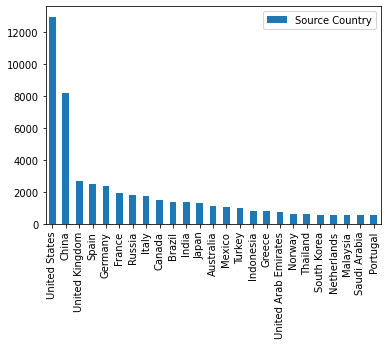

In [ ]:
display(routes['Source Country'].value_counts())
routes['Source Country'].value_counts()[:25].to_frame().plot.bar()

United States              12967
China                       8174
United Kingdom              2635
Spain                       2530
Germany                     2336
                           ...  
Falkland Islands               1
Tuvalu                         1
Lesotho                        1
Swaziland                      1
Cocos (Keeling) Islands        1
Name: Destination Country, Length: 224, dtype: int64

<AxesSubplot:>

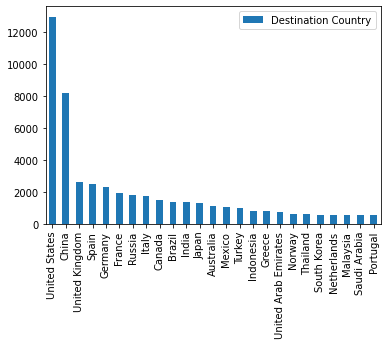

In [ ]:
display(routes['Destination Country'].value_counts()) #What country is missing from this dataset?
routes['Destination Country'].value_counts()[:25].to_frame().plot.bar()

Top 5 countries are the same. That is interesting


Finding most popular models given popular source countries:

In [ ]:
us_source_routes = routes[routes['Source Country'] == "United States"]
display(us_source_routes['Plane Model'].value_counts()[:10])

ch_source_routes = routes[routes['Source Country'] == "China"]
display(ch_source_routes['Plane Model'].value_counts()[:10])

uk_source_routes = routes[routes['Source Country'] == "United Kingdom"]
display(uk_source_routes['Plane Model'].value_counts()[:10])

Airbus A320                  559
Boeing 737-800               489
Airbus A319                  472
Canadair Regional Jet 700    293
Embraer RJ145                216
Boeing 757                   199
Boeing 767-300               184
Saab SF340A/B                163
Boeing 717                   160
McDonnell Douglas MD-88      145
Name: Plane Model, dtype: int64

Boeing 737-800               1775
Airbus A320                  1695
Boeing 737                   1213
Airbus A319                   740
Embraer 190                   301
Airbus A321                   293
Boeing 737-700                106
Boeing 737-300                 71
Canadair Regional Jet 900      70
Airbus A330-300                60
Name: Plane Model, dtype: int64

Boeing 737-800                           412
Airbus A320                              204
Airbus A319                              170
De Havilland Canada DHC-8-400 Dash 8Q     93
Boeing 777                                83
Airbus A321                               67
Boeing 737-300                            65
Boeing 747-400                            48
Boeing 757-200                            45
Saab SF340A/B                             25
Name: Plane Model, dtype: int64

In [ ]:
display(us_source_routes['Destination Country'].value_counts())
display(ch_source_routes['Destination Country'].value_counts())
display(uk_source_routes['Destination Country'].value_counts())

United States     10471
Mexico              369
Canada              364
United Kingdom      207
Germany             114
                  ...  
American Samoa        1
Samoa                 1
Ghana                 1
Morocco               1
Cape Verde            1
Name: Destination Country, Length: 94, dtype: int64

China           6976
Taiwan           191
South Korea      152
Japan            140
Hong Kong        118
                ... 
Turkmenistan       1
Algeria            1
Georgia            1
Angola             1
Brunei             1
Name: Destination Country, Length: 64, dtype: int64

Spain             518
United Kingdom    309
United States     203
France            158
Italy             141
                 ... 
Argentina           1
Albania             1
Belarus             1
Moldova             1
Oman                1
Name: Destination Country, Length: 100, dtype: int64

A lot of domestic flights within US and China, might want to check against only international flights.

In [ ]:
us_dest_routes = routes[routes['Destination Country'] == "United States"]
display(us_dest_routes['Plane Model'].value_counts()[:10])

ch_dest_routes = routes[routes['Destination Country'] == "China"]
display(ch_dest_routes['Plane Model'].value_counts()[:10])

uk_dest_routes = routes[routes['Destination Country'] == "United Kingdom"]
display(uk_dest_routes['Plane Model'].value_counts()[:10])

Airbus A320                  558
Boeing 737-800               493
Airbus A319                  470
Canadair Regional Jet 700    293
Embraer RJ145                215
Boeing 757                   200
Boeing 767-300               183
Saab SF340A/B                163
Boeing 717                   160
Canadair Regional Jet 900    144
Name: Plane Model, dtype: int64

Boeing 737-800               1776
Airbus A320                  1693
Boeing 737                   1213
Airbus A319                   739
Embraer 190                   301
Airbus A321                   293
Boeing 737-700                106
Boeing 737-300                 71
Canadair Regional Jet 900      70
Airbus A330-300                59
Name: Plane Model, dtype: int64

Boeing 737-800                           412
Airbus A320                              203
Airbus A319                              171
De Havilland Canada DHC-8-400 Dash 8Q     93
Boeing 777                                84
Boeing 737-300                            65
Airbus A321                               63
Boeing 747-400                            49
Boeing 757-200                            46
Saab SF340A/B                             25
Name: Plane Model, dtype: int64

Most of the planes entering the country seem to be leaving the country. This is interesting, but it's to be expected. 

In [ ]:
display(us_dest_routes['Source Country'].value_counts())
display(ch_dest_routes['Source Country'].value_counts())
display(uk_dest_routes['Source Country'].value_counts())

United States       10471
Mexico                373
Canada                362
United Kingdom        203
Germany               114
                    ...  
Ukraine                 1
Morocco                 1
Guam                    1
Marshall Islands        1
Cape Verde              1
Name: Source Country, Length: 92, dtype: int64

China           6976
Taiwan           191
South Korea      151
Japan            140
Hong Kong        117
                ... 
Georgia            1
Angola             1
Algeria            1
Turkmenistan       1
Mexico             1
Name: Source Country, Length: 63, dtype: int64

Spain             512
United Kingdom    309
United States     207
France            157
Italy             141
                 ... 
Maldives            1
Bahamas             1
Albania             1
Bangladesh          1
Oman                1
Name: Source Country, Length: 100, dtype: int64

Airbus A320                   9091
Boeing 737-800                7080
Airbus A319                   3393
Boeing 737                    2187
Aerospatiale/Alenia ATR 72    1136
                              ... 
Airbus A340-200                  4
McDonnell Douglas MD-11          4
Yakovlev Yak-40                  4
Sikorsky S-76                    2
BAe 146-100                      2
Name: Plane Model, Length: 113, dtype: int64

<AxesSubplot:>

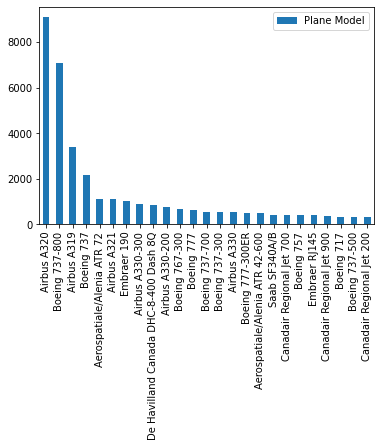

In [ ]:
display(routes['Plane Model'].value_counts())
routes['Plane Model'].value_counts()[:25].to_frame().plot.bar()

###Long distance flights



In [ ]:
long_dist_routes = routes[routes['Distance (KM)'] >= 5000]
long_dist_routes

,IATA/ICAO Code,Airline,Airline ID,Source Airport,Source Country,Source Airport ID,Destination Airport,Destination Country,Destination Airport ID,Distance (KM),Plane Model,Stops,Codeshare
Index W.R.T. Origin,,,,,,,,,,,,,
186,2P,Air Philippines,897,Al Maktoum International Airport,United Arab Emirates,8076,Ninoy Aquino International Airport,Philippines,2397,6938.316898,Airbus A330,0,0
196,2P,Air Philippines,897,Ninoy Aquino International Airport,Philippines,2397,Al Maktoum International Airport,United Arab Emirates,8076,6938.316898,Airbus A330,0,0
642,3U,Sichuan Airlines,4608,Chongqing Jiangbei International Airport,China,3393,Sydney Kingsford Smith International Airport,Australia,3361,8461.501184,Airbus A330,0,0
690,3U,Sichuan Airlines,4608,Chengdu Shuangliu International Airport,China,3395,Melbourne International Airport,Australia,3339,8671.064608,Airbus A330,0,0
837,3U,Sichuan Airlines,4608,Melbourne International Airport,Australia,3339,Chengdu Shuangliu International Airport,China,3395,8671.064608,Airbus A330,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
65623,XY,Nas Air,3754,King Abdulaziz International Airport,Saudi Arabia,2072,Soekarno-Hatta International Airport,Indonesia,3275,7973.639120,Airbus A330,0,0
65634,XY,Nas Air,3754,King Abdulaziz International Airport,Saudi Arabia,2072,Kuala Lumpur International Airport,Malaysia,3304,7070.862742,Airbus A330,0,0
65647,XY,Nas Air,3754,Kuala Lumpur International Airport,Malaysia,3304,King Abdulaziz International Airport,Saudi Arabia,2072,7070.862742,Airbus A330,0,0


In [ ]:
international_routes = routes[routes['Source Country'] != routes['Destination Country']]
international_routes

,IATA/ICAO Code,Airline,Airline ID,Source Airport,Source Country,Source Airport ID,Destination Airport,Destination Country,Destination Airport ID,Distance (KM),Plane Model,Stops,Codeshare
Index W.R.T. Origin,,,,,,,,,,,,,
11,2B,Aerocondor,410,Heydar Aliyev International Airport,Azerbaijan,2922,Begishevo Airport,Russia,6969,1685.392112,Canadair Regional Jet 200,0,0
25,2B,Aerocondor,410,Begishevo Airport,Russia,6969,Heydar Aliyev International Airport,Azerbaijan,2922,1685.392112,Canadair Regional Jet 200,0,0
81,2J,Air Burkina,470,Port Bouet Airport,Cote d'Ivoire,253,Bobo Dioulasso Airport,Burkina Faso,247,653.905374,NaN,0,0
82,2J,Air Burkina,470,Port Bouet Airport,Cote d'Ivoire,253,Ouagadougou Airport,Burkina Faso,246,828.044395,NaN,0,0
83,2J,Air Burkina,470,Kotoka International Airport,Ghana,248,Ouagadougou Airport,Burkina Faso,246,760.856470,NaN,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
67507,ZI,Aigle Azur,21,Toulouse-Blagnac Airport,France,1273,Houari Boumediene Airport,Algeria,210,786.314943,NaN,0,0
67508,ZI,Aigle Azur,21,Toulouse-Blagnac Airport,France,1273,Es Senia Airport,Algeria,231,904.911332,NaN,0,0
67509,ZI,Aigle Azur,21,Vnukovo International Airport,Russia,2988,Paris-Orly Airport,France,1386,2476.274912,Airbus A320,0,0


United States              2503
United Kingdom             2352
Germany                    2139
Spain                      1949
France                     1442
                           ... 
Falkland Islands              1
Lesotho                       1
Swaziland                     1
Tuvalu                        1
Cocos (Keeling) Islands       1
Name: Source Country, Length: 225, dtype: int64

<AxesSubplot:>

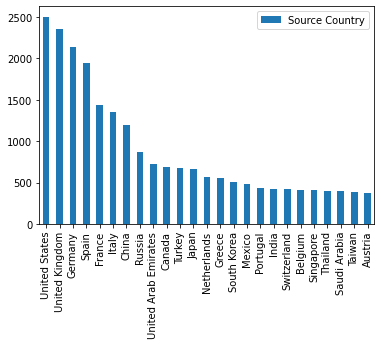

In [ ]:
display(international_routes['Source Country'].value_counts())
international_routes['Source Country'].value_counts()[:25].to_frame().plot.bar()

United States              2496
United Kingdom             2326
Germany                    2124
Spain                      1952
France                     1438
                           ... 
American Samoa                1
Lesotho                       1
Swaziland                     1
Tuvalu                        1
Cocos (Keeling) Islands       1
Name: Destination Country, Length: 224, dtype: int64

<AxesSubplot:>

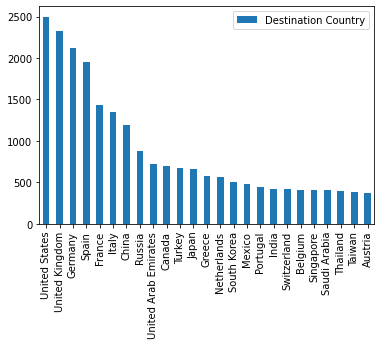

In [ ]:
display(international_routes['Destination Country'].value_counts()) #What country is missing from this dataset?
international_routes['Destination Country'].value_counts()[:25].to_frame().plot.bar()

China loses its top 5 spot when only international flights are considered. Way more European countries are pretent towards the top of the list

In [ ]:
routes[routes['Stops'] >0]

,IATA/ICAO Code,Airline,Airline ID,Source Airport,Source Country,Source Airport ID,Destination Airport,Destination Country,Destination Airport ID,Distance (KM),Plane Model,Stops,Codeshare
Index W.R.T. Origin,,,,,,,,,,,,,
2066,5T,Canadian North,1623,Rankin Inlet Airport,Canada,132,Arviat Airport,Canada,50,217.117244,Aerospatiale/Alenia ATR 42-600,1,0
7810,AC,Air Canada,330,Port Bouet Airport,Cote d'Ivoire,253,Brussels Airport,Belgium,302,5119.644729,Airbus A330-300,1,0
8272,AC,Air Canada,330,Vancouver International Airport,Canada,156,Campbell River Airport,Canada,30,172.830232,Beechcraft 1900,1,0
17767,CU,Cubana de Aviación,1936,Leonardo da Vinci–Fiumicino Airport,Italy,1555,José Martí International Airport,Cuba,1909,8709.383347,Boeing 767,1,0
25116,FL,AirTran Airways,1316,William P Hobby Airport,United States,3566,San Antonio International Airport,United States,3621,309.375402,Boeing 737-500,1,0
25220,FL,AirTran Airways,1316,Orlando International Airport,United States,3878,William P Hobby Airport,United States,3566,1366.537468,NaN,1,0
25230,FL,AirTran Airways,1316,Orlando International Airport,United States,3878,Norfolk International Airport,United States,3611,1053.529824,Boeing 717,1,0
49746,SK,Scandinavian Airlines System,4319,Stockholm-Arlanda Airport,Sweden,737,Gällivare Airport,Sweden,715,846.072942,British Aerospace ATP,1,0
63567,WN,Southwest Airlines,4547,General Edward Lawrence Logan International Ai...,United States,3448,Orlando International Airport,United States,3878,1804.114237,NaN,1,0


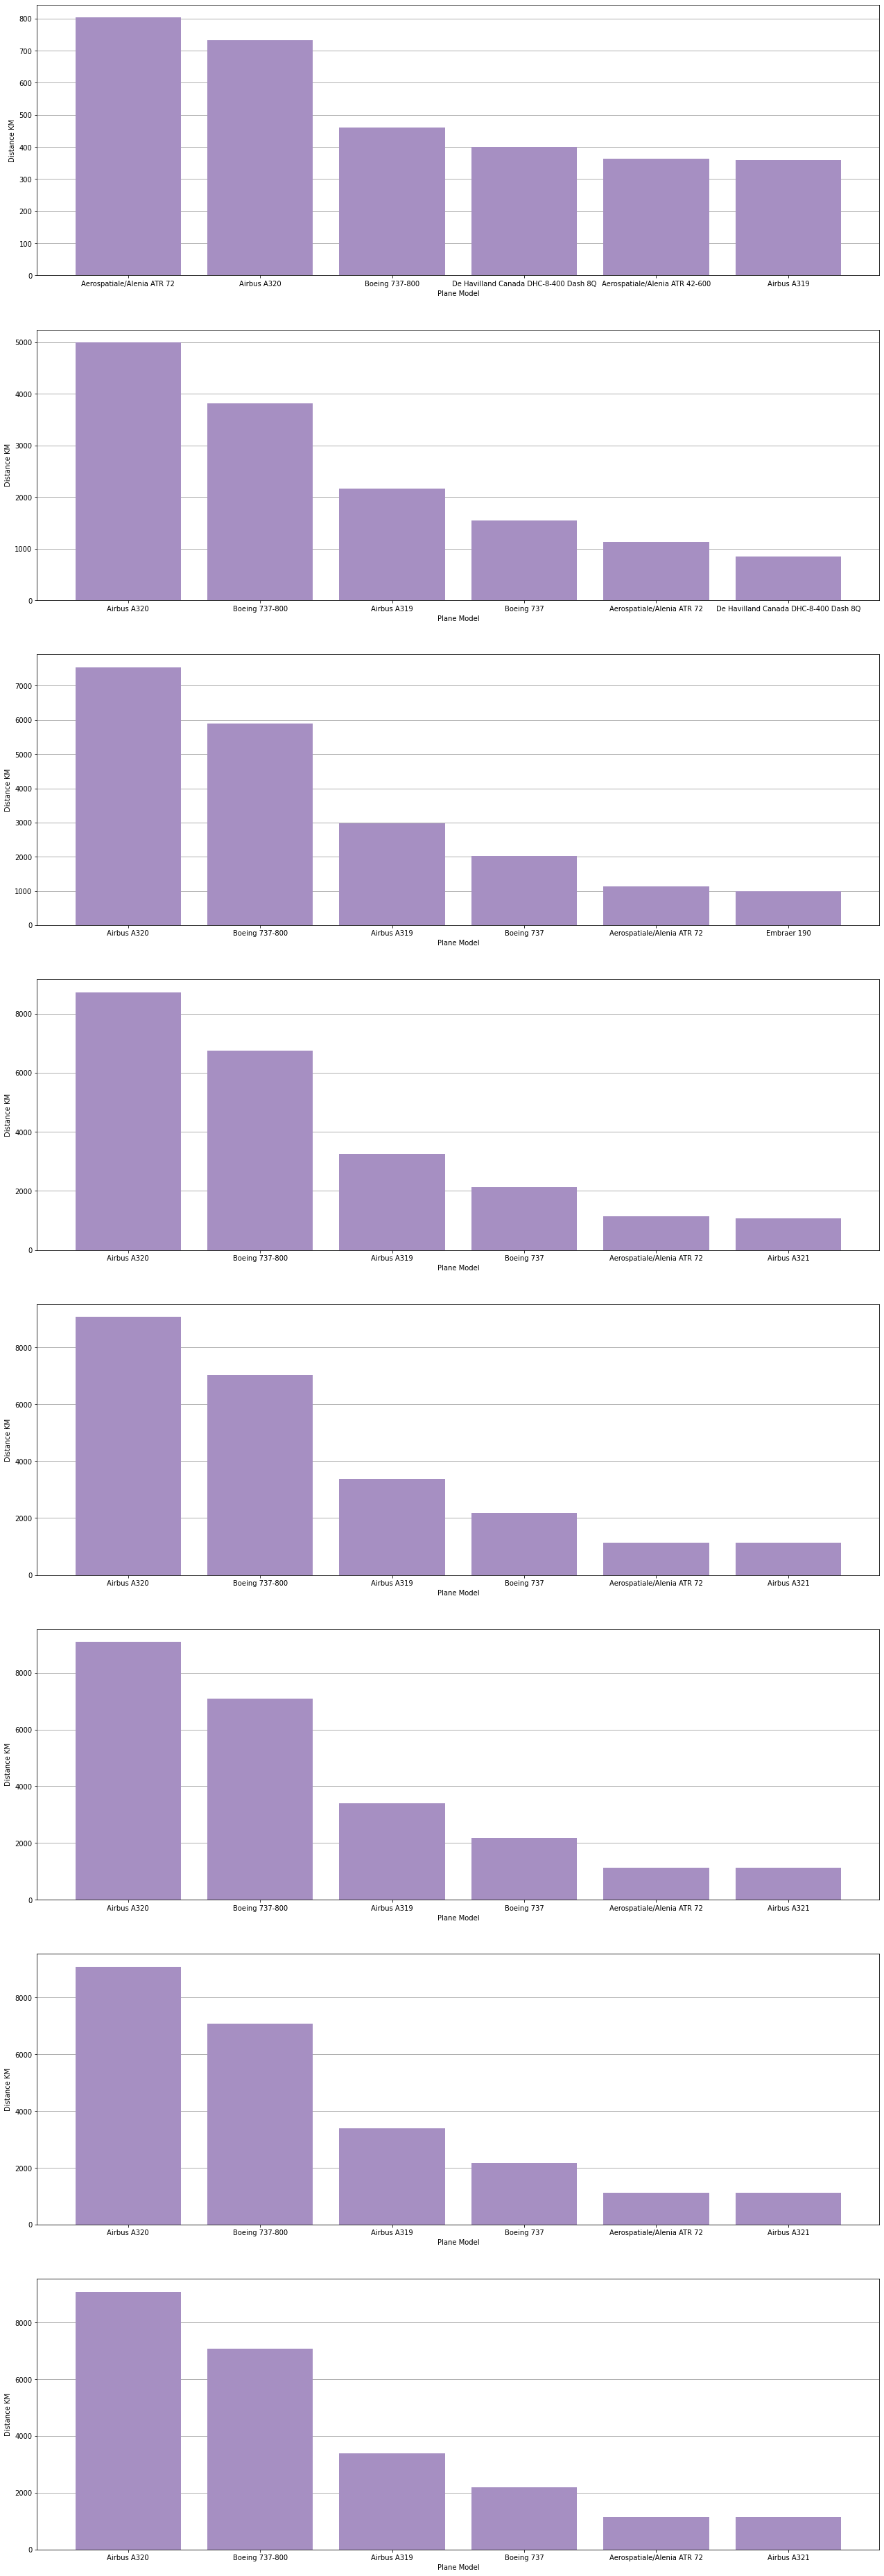

In [ ]:
fig, axs = plt.subplots(8, 1, figsize=(5,30))

# loop through plots, plotting 1000..8000 distance
#plot1 = routes[routes['Distance (KM)'] < 400]['Plane Model'].value_counts()[:10].plot.bar()
for i in range(8):
  x = routes[routes['Distance (KM)'] < (i * 1000) + 500]['Plane Model'].value_counts()[:6]
  y = routes[routes['Distance (KM)'] < (i* 1000)+ 500]['Plane Model'].value_counts()[:6].index
  axs[i].bar(y, x, color = "#a68fc2")
  # grid
  axs[i].set_axisbelow(True)
  axs[i].yaxis.grid(color = "#9c9c9c")
  # axis labels
  axs[i].set_xlabel("Plane Model")
  axs[i].set_ylabel("Distance KM")
  plt.subplots_adjust(bottom = 0.3, right = 3.5, top = 2)

#Machine Learning Aspect
* Use all columns but Equipment (model of plane) as x, try to predict model of plane 
 * baseline: if our model is more than 1/3 accurate

In [ ]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

def get_splits(routes_df):
  # routes_df is either origional (cleaned) 
  # routes or a subset of routes with the
  # same columns
  X_train, X_other, Y_train, Y_other = sklearn.model_selection.train_test_split(routes_df.drop(columns = 'Plane Model'), routes_df['Plane Model'], test_size = 0.333, random_state = 747)
  X_validation, X_test, Y_validation, Y_test = sklearn.model_selection.train_test_split(X_other, Y_other, test_size = .5, random_state = 747)
  return {'X_train' : X_train, 'X_val' :X_validation, 'X_test' : X_test, 'Y_train':Y_train,'Y_val': Y_validation,'Y_test': Y_test}

In [ ]:
splits = get_splits(routes)

splits['Y_val']

Index W.R.T. Origin
62689       Airbus A320
51366               NaN
31182    Boeing 737-800
27002    Boeing 737-800
65459    Boeing 737-800
              ...      
36510               NaN
61105               NaN
54500       Airbus A319
67042    Boeing 737-800
41663               NaN
Name: Plane Model, Length: 11039, dtype: object

Some of the elements in `Plane Model` column are NaN. Need to check if that's the case in the origional file, or if there's an issue with the mapping. 

In [ ]:
#Element at index 9022 should have equipment `CR9`
planes[planes['IATA Code'] == 'CR9'] # A lot of `Plane Model` elements are NaN, but shouldn't be. There's something wrong with the initial mapping, need to revaluate

,Plane Name,IATA Code,ICAO Code
122,Canadair Regional Jet 900,CR9,CRJ9


# Machine Learning

In [ ]:
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.cluster import KMeans
import scipy
from scipy.stats import zscore

In [ ]:
# Importing the dataset and selecting all plane models with more than 35 flights
allnoNaN = pd.read_csv("/content/routes_clean.csv")
flightmore35 = allnoNaN.loc[allnoNaN["Plane Model"].isin(allnoNaN["Plane Model"].unique()[allnoNaN["Plane Model"].value_counts() > 35])]

In [ ]:
# Getting the initial X inputs and y outputs
Xall = flightmore35[["Airline ID", "Source Airport ID","Destination Airport ID","Distance (KM)","Codeshare"]]
yall = flightmore35[["Plane Model"]]
source = flightmore35[["Source Country"]]
destination = flightmore35[["Destination Country"]]

# Setting up the label Encoders
labeling = preprocessing.LabelEncoder()

# Encoding the y so it can be used my regression systems
labeling.fit(yall)
labelyall = labeling.transform(yall)

# Encoding the source and destination countries and adding them to the X inputs
labeling.fit(source)
labelsource = labeling.transform(source)
labeling.fit(destination)
labeldestination = labeling.transform(destination)
Xall["Source Country"] = labelsource
Xall["Destination Country"] = labeldestination

# Z scoring the inputs
Xall = Xall.apply(zscore)

# Setting up the splits
Xtrain, Xtemp, ytrain, ytemp = train_test_split(Xall, labelyall, test_size=.2, random_state=747)
Xval, Xtest, yval, ytest = train_test_split(Xtemp, ytemp, train_size=.5, random_state=747)

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shap

In [ ]:
# Testing different amount of clusters
for x in range(100,125):
  kmeans = KMeans(n_clusters=x, random_state=0, n_init="auto").fit(Xtrain)
  ypred = kmeans.predict(Xtrain)
  trainscore = kmeans.score(Xtrain, ytrain)
  valscore = kmeans.score(Xval, yval)
  display("Train: " + str(trainscore) + " Val: " + str(valscore))

'Train: -25811.51663965574 Val: -3267.508288804065'

'Train: -25660.055521734364 Val: -3249.788695009162'

'Train: -25472.290089073198 Val: -3224.780500606328'

'Train: -25314.184355940823 Val: -3216.3513252677485'

'Train: -25153.881205674646 Val: -3198.817634058538'

'Train: -25011.65076276921 Val: -3178.683663372085'

'Train: -24950.839236363645 Val: -3170.3020380952194'

'Train: -24820.497729620656 Val: -3150.113817708252'

'Train: -24693.472507528786 Val: -3132.909019703773'

'Train: -24645.252293294 Val: -3124.2734938024623'

'Train: -24462.63238418505 Val: -3103.2059564144474'

'Train: -24338.339500846563 Val: -3083.5036228886793'

'Train: -24194.25636195117 Val: -3074.7155541017282'

'Train: -24096.737654102148 Val: -3070.4122547089555'

'Train: -23898.55894808069 Val: -3052.247993697918'

'Train: -23783.73881528707 Val: -3033.8572567120773'

'Train: -23723.556943285184 Val: -3030.2013257078065'

'Train: -23645.86641441821 Val: -3026.7981320088165'

'Train: -23482.813126366123 Val: -3000.3816824317732'

'Train: -23396.38967687742 Val: -2990.1402476491576'

'Train: -23352.14153760353 Val: -2988.4614420518274'

'Train: -23345.977174643867 Val: -2996.0514413991705'

'Train: -23255.433137342246 Val: -2981.445130236312'

'Train: -23161.59744728447 Val: -2970.625617779616'

'Train: -23041.64153016675 Val: -2962.242832309873'

In [ ]:
# Testing various polynomials
for x in range(1,7):
  poly = PolynomialFeatures(degree = x, include_bias = False)
  # Setting up the feature for the polynomial model
  trainfeatures = poly.fit_transform(Xtrain)
  valfeatures = poly.fit_transform(Xval)
  # Training the polynomial model on the dataset
  polymodel = LinearRegression()
  polymodel.fit(trainfeatures, ytrain)
  # Getting the coefficient of the model, the intercept, and the training and validation scores of the model
  polycoef = polymodel.coef_
  polyinter = polymodel.intercept_
  trainscore = polymodel.score(trainfeatures, ytrain)
  valscore = polymodel.score(valfeatures, yval)
  display("degree: " + str(x) + " train: " + str(trainscore) + " val: " + str(valscore))

'degree: 1 train: 0.026930509029066685 val: 0.023369395557679584'

'degree: 2 train: 0.09811975233791659 val: 0.09037200431936565'

'degree: 3 train: 0.14725867056475028 val: 0.13090673139627385'

'degree: 4 train: 0.1899756760683624 val: 0.17017243690287231'

'degree: 5 train: 0.22069756132333695 val: 0.17699150652509132'

'degree: 6 train: 0.2813174135377311 val: -0.07085394372564857'

In [ ]:
# Initializing the Polynomial features to have a polynomial regression
poly = PolynomialFeatures(degree = 5, include_bias = False)
# Setting up the feature for the polynomial model
trainfeatures = poly.fit_transform(Xtrain)
valfeatures = poly.fit_transform(Xval)
# Training the polynomial model on the dataset
polymodel = LinearRegression()
polymodel.fit(trainfeatures, ytrain)
# Getting the coefficient of the model, the intercept, and the training and validation scores of the model
polycoef = polymodel.coef_
polyinter = polymodel.intercept_
trainscore = polymodel.score(trainfeatures, ytrain)
valscore = polymodel.score(valfeatures, yval)
display("degree: " + str(5) + " train: " + str(trainscore) + " val: " + str(valscore))

'degree: 5 train: 0.22069756132333695 val: 0.17699150652509132'

In [ ]:
# Testing linear regression
lin = LinearRegression().fit(Xtrain, ytrain)
lin.score(Xtrain, ytrain)
lin.coef_

array([ 1.00304503,  0.3944693 ,  0.51695854, -0.17842813,  2.05658141,
        0.90854101,  0.95547626])